# Overview
## 배경
* Covid-19의 확산으로 감염 확산 방지를 위해 마스크 착용이 의무화
    * 따라서 공공 장소에 있는 사람들은 반드시 마스크를 착용해야 할 필요가 있음.
    * 또 코와 입을 완전히 가릴 수 있도록 올바르게 착용하는 것이 중요
* 하지만 넓은 공공장소에서 모든 사람들의 올바른 마스크 착용 상태를 검사하기 위해선 추가 인적 자원이 필요
   * 따라서 사람 얼굴 이미지 만으로 이 사람이 마스크를 쓰고 있는지, 정확히 쓴 것이 맞는지 자동으로 가려낼 시스템을 만들어 내 보려고 함
   
## 평가 방법
### 제출
* 방법
    * 노트북: https://nbviewer.org/gist/MoMentum99/0b01597b72e008646b4d3bef50c55bed/sample_submission.ipynb
    * inference.py:
        * 파일의 실행 형식은 다음과 같습니다
            ```SM_CHANNEL_EVAL=[dataset dir] SM_CHANNEL_MODEL=[model saved dir] SM_OUTPUT_DATA_DIR=[inference output dir] python inference.py --model [your model class]```

            * SM_CHANNEL_EVAL: 평가 데이터셋이 위치하는 폴더

            * SM_CHANNEL_MODEL: 학습된 모델(best.pth) 가 위치하는 폴더

            * SM_OUTPUT_DATA_DIR: 모델의 예측값을 csv 파일로 저장하는 폴더

            * (optional) model: Custom Model 를 통해 학습을 진행하였을 경우, 해당 모델의 이름

        * 위 형식으로 실행하면 SM_OUTPUT_DATA_DIR 폴더에 테스트 셋의 예측값이 submission.csv 이름으로 저장이 됩니다
        
* 제출 형식(submission.csv)
    ```
    ImageID,ans
    a41280fcf20d5bb68550876c36b63e9d030b2324.jpg,0
    2b721e63790fd041b5440f05647afc9266fa05bd.jpg,0
    3931a1e7ee6fd45f313436ab68d0f556a25e4d25.jpg,0
    4b30021def42c080bb7744d15b50b3a381d9cb4f.jpg,0
    b57eca823bdbf49272c75354bf0e0d3d8fc119d7.jpg,0
    075bbf401dd04ad6154bc508875d8910e08116e8.jpg,0
    f740f5a296b8d5331ae47907bd51126bb0e70697.jpg,0
    c90c83435d9c8c3f1fdc3ee6c7f65478f72f4967.jpg,0
    b7e19ad2552e1f27a4b2c8a93c1284bfa2d5176e.jpg,0
    b5930a21e7a24290cbf63cc93798705cfce09d16.jpg,0
    b862db486a2f118412858a1369ef30b14b90cbee.jpg,0
    d80bd7fff0e6bfc64092fac7a20c14ecdb8fda3f.jpg,0
    ...
    ```
    * ImageID, ans 형식으로 헤더 포함
    
### 평가
* f1 score를 통해 평가
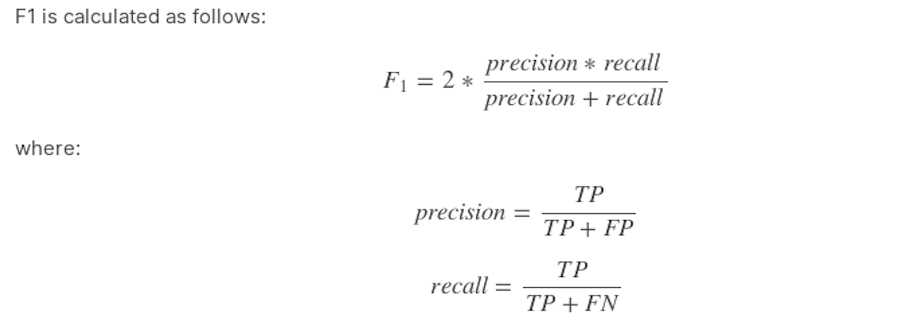

# 데이터
## 학습 데이터셋
* 구성
    * 아시안, 남녀, 20대 ~ 70대
* 통계
    * 전체 사람 명수: 4,500
    * 한 사람 당 사진 개수: 7
        * 마스크 착용 5장, 올바르게 착용하지 않은 경우 1장, 미착용 1장
    * 이미지 크기: (384, 512)
    * 전체 데이터셋의 60%가 학습 데이터셋으로 활용
* 클래스: 총 18개의 클래스
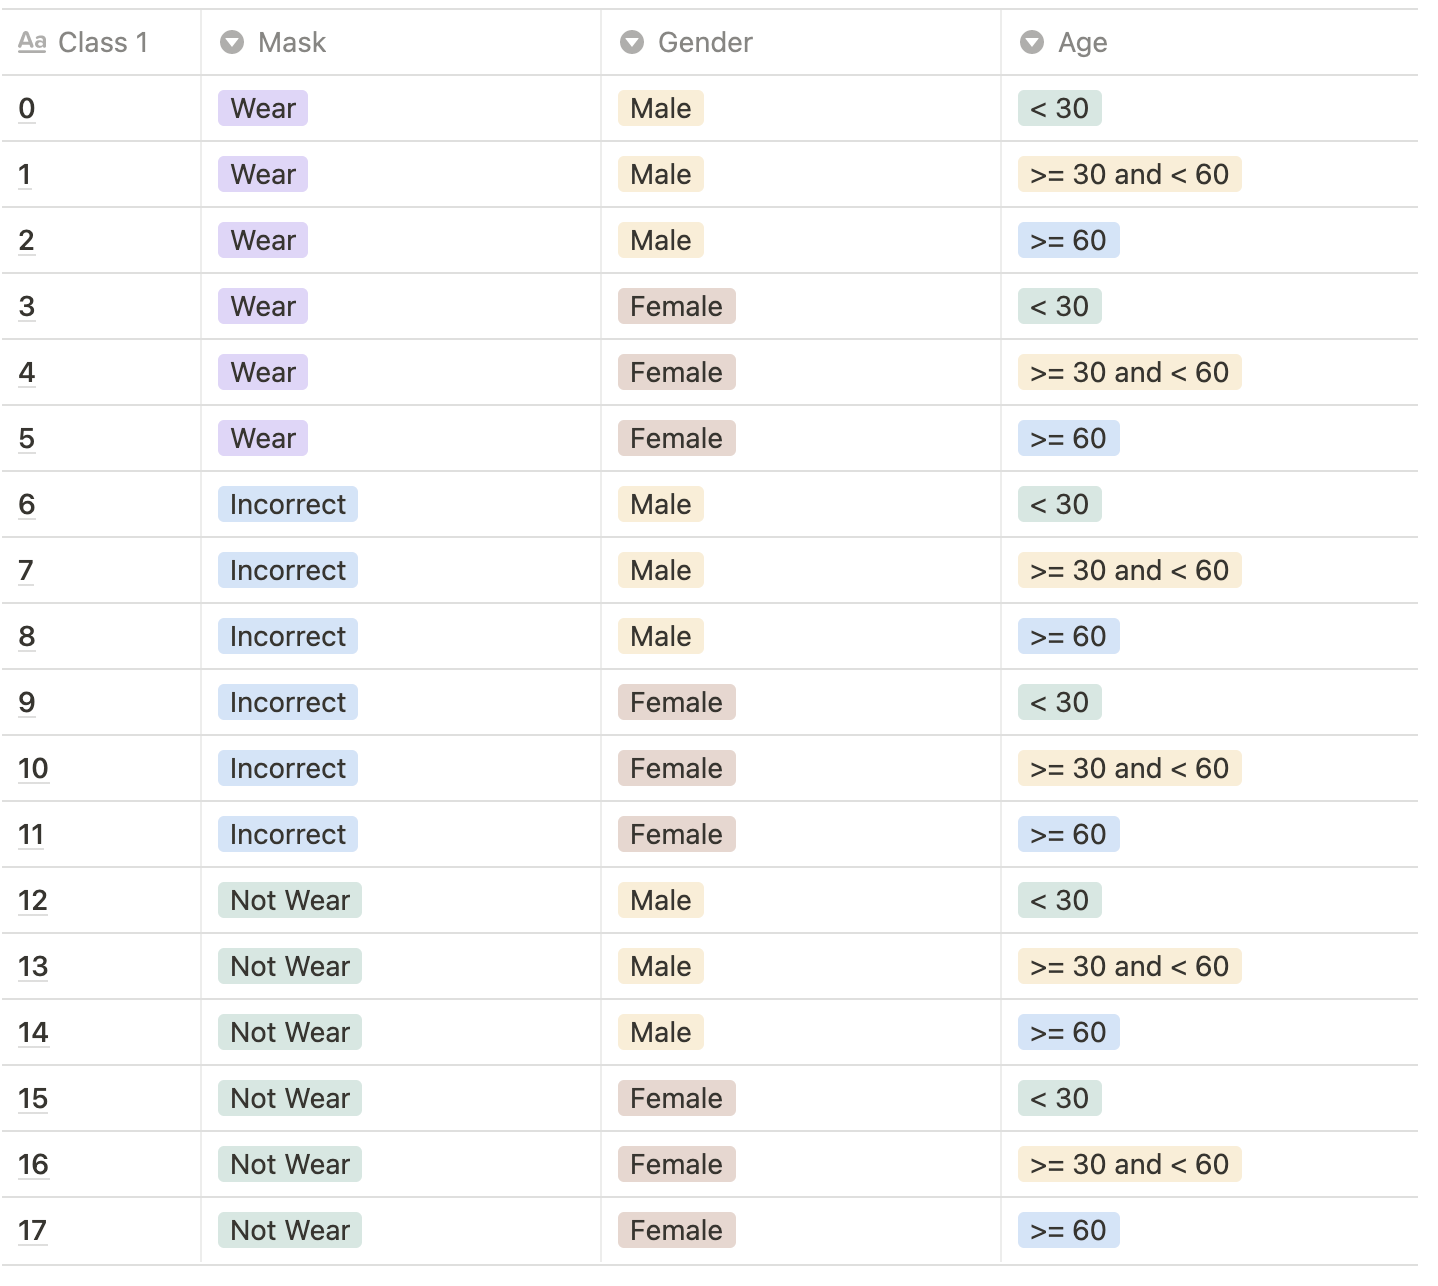

## 평가 데이터셋
* 나머지 40%개의 데이터셋 중
    * 20%: public 테스트셋
    * 20%: private 테스트셋
* 최종 순위는 private 테스트셋을 통해 산출한 점수로 확정

## 데이터 구조


In [14]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

In [15]:
list_files('./data')

* mask1 ~ mask5: 마스크 착용
* normal: 마스크 미착용
* incorrect_mask: 마스크 올바르게 착용하지 않은 경우

# EDA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import os, sys
import skimage.io
from skimage.transform import resize
#!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio
#!pip install --no-dependencies imgaug
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import f1_score, fbeta_score
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

/opt/conda/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## 사진 확인

In [6]:
!pwd

/opt/ml/code/level1-image-classification-level1-nlp-6


In [7]:
df_train = pd.read_csv('/opt/ml/input/data/train/train.csv')

CPU times: user 140 ms, sys: 36 ms, total: 176 ms
Wall time: 129 ms


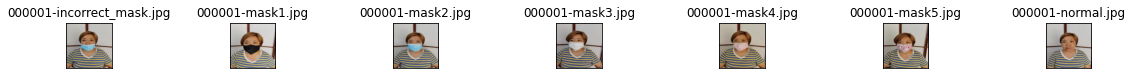

In [6]:
%%time
fig = plt.figure(figsize=(20, 100))

# display 10 images from each class
for i in range(1):
    row = df_train.loc[i]
    path=f"/opt/ml/input/data/train/images/{row['path']}"
    folders = sorted([f for f in os.listdir(path) if '._' not in f])
    
    for j, img in enumerate(folders):
        ax = fig.add_subplot(100, 7, i * 7 + j + 1, xticks=[], yticks=[])
        image = cv2.imread(path + "/" + img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('%s-%s' % (row['id'], img))
        

# 폴더로 구성되어 있는 이미지 한 폴더로 넣어주기
    * 003106_female_Asian_20+incorrect_mask.jpg
    * 003106_female_Asian_20+mask1.jpg
    * 003106_female_Asian_20+mask2.jpg
    * 003106_female_Asian_20+mask3.jpg
    * 003106_female_Asian_20+mask4.jpg
    * 003106_female_Asian_20+mask5.jpg
    * 003106_female_Asian_20+normal.jpg


In [18]:
df_train.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [8]:
df_train_class = pd.DataFrame(columns = ['id', 'per_id', 'gender', 'age', 'mask', 'class', 'path'])
df_train_class.set_index('id', inplace=True)

In [9]:
def return_class_simple(row, mask):
    # Assuming the mask is already labeled as 0,1,2
    # Each of them is 'wear', 'incorrect' and 'not wear'
    gender = 0 if row["gender"] == "male" else 3
    age = min(2, row["age"] // 30)

    # Print the class number
    return mask*6 + gender + age, age

In [10]:
path = '../../input/data/train/images'

!rm -rf ./data/train/.DS_Store
!rm -rf ./data/train/images/.DS_Store
folders = sorted([f for f in os.listdir(path) if "._" not in f])

In [11]:
idx = 0
mask_dict = {0: 'wear', 1: 'not wear', 2: 'incorrect'}
age_dict = {0: 'under 30', 1: '30 to 60', 2: 'over 60'}

for i in df_train.index:
    row = df_train.loc[i]
    imgs_path = os.path.join(path, row['path'])
    images = sorted([f for f in os.listdir(imgs_path) if "._" not in f])
    for img in images:
        #print(img)
        if img[:-4] == 'incorrect_mask':
            mask = 2 # incorrect
        elif img[:-4] == 'normal':
            mask = 1 # not wear
        else:
            mask = 0 # wear

        classnum, age = return_class_simple(row, mask)
        

        df_train_class.loc[idx] = [row['id'], row['gender'], age_dict[age], mask_dict[mask], classnum, os.path.join(imgs_path, img)]
        idx += 1


In [27]:
df_train_class.head()

,per_id,gender,age,mask,class,path
id,,,,,,
0,000001,female,30 to 60,incorrect,16,../../input/data/train/images/000001_female_As...
1,000001,female,30 to 60,wear,4,../../input/data/train/images/000001_female_As...
2,000001,female,30 to 60,wear,4,../../input/data/train/images/000001_female_As...
3,000001,female,30 to 60,wear,4,../../input/data/train/images/000001_female_As...
4,000001,female,30 to 60,wear,4,../../input/data/train/images/000001_female_As...


# 시각화
## 성별 - 마스크 착용

In [ ]:
group = df_train_class.groupby('gender')['mask'].value_counts().sort_index()
display(group)
print(df_train_class['gender'].value_counts())

gender  mask     
female  incorrect     1639
        not wear      1639
        wear         19934
male    incorrect     1010
        not wear      1010
        wear         12568
Name: mask, dtype: int64

female    23212
male      14588
Name: gender, dtype: int64


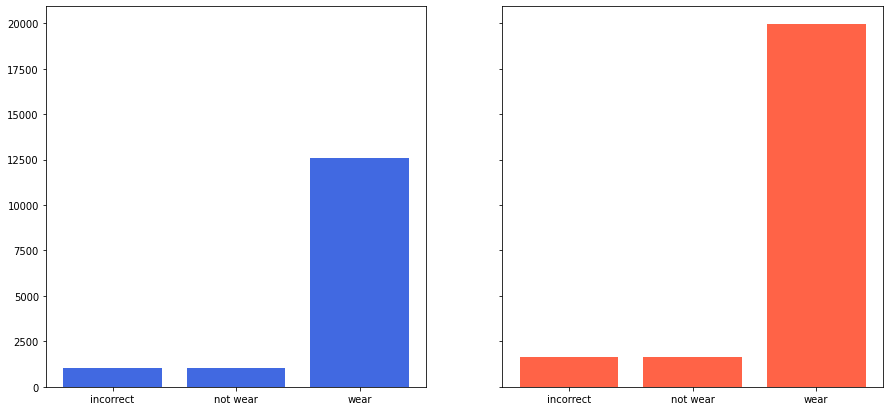

In [ ]:
# 동시에 두 그래프를 그리는 경우 sharey를 하면 두 그래프의 y축 범주를 맞출 수 있다
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True) 
axes[0].bar(group['male'].index, group['male'], color='royalblue')
axes[1].bar(group['female'].index, group['female'], color='tomato')
plt.show()

## 나이 - 마스크 착용

In [ ]:
group = df_train_class.groupby('age')['mask'].value_counts().sort_index()
display(group)
print(df_train_class['age'].value_counts())

age       mask     
30 to 60  incorrect     1227
          not wear      1227
          wear         14724
over 60   incorrect      192
          not wear       192
          wear          2304
under 30  incorrect     1230
          not wear      1230
          wear         15474
Name: mask, dtype: int64

under 30    17934
30 to 60    17178
over 60      2688
Name: age, dtype: int64


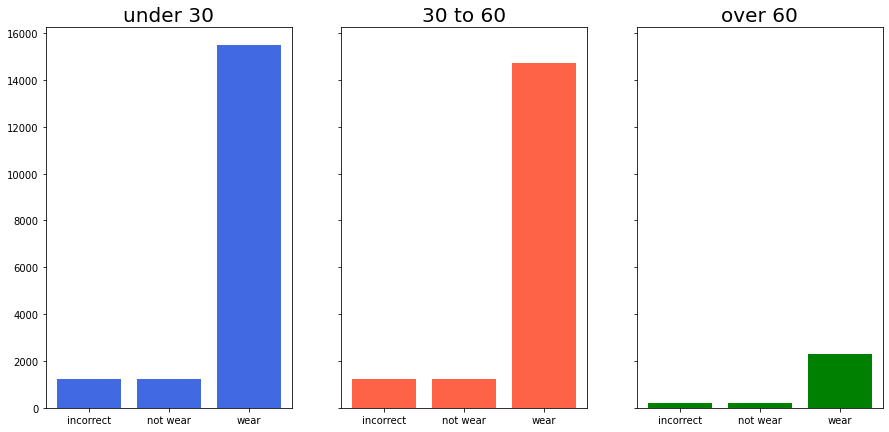

In [ ]:
# 동시에 두 그래프를 그리는 경우 sharey를 하면 두 그래프의 y축 범주를 맞출 수 있다
fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True) 
axes[0].bar(group['under 30'].index, group['under 30'], color='royalblue')
axes[0].set_title('under 30', fontsize=20)

axes[1].bar(group['30 to 60'].index, group['30 to 60'], color='tomato')
axes[1].set_title('30 to 60', fontsize=20)

axes[2].bar(group['over 60'].index, group['over 60'], color='green')
axes[2].set_title('over 60', fontsize=20)


plt.show()

## 클래스 별
* '30 to 60'과 'over 60' 데이터가 많이 부족함

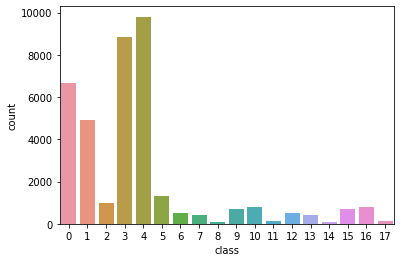

In [ ]:
sns.countplot(x='class',data=df_train_class,
             order=sorted(df_train_class['class'].unique())
             
             )

## 이미지 채널별 평ㄱㄴ

In [14]:
!pwd

/opt/ml/code/level1-image-classification-level1-nlp-6


In [35]:
%%time
fig = plt.figure(figsize=(20, 100))


r_mean = []
g_mean = []
b_mean = []

# display 10 images from each class
for i in range(len(df_train_class)):
    row = df_train_class.loc[i]

    image = cv2.imread(row['path'])
    #print(image.shape) # 이미지 크기

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    r = np.array(image)[:, :, 0]
    g = np.array(image)[:, :, 1]
    b = np.array(image)[:, :, 2]

    r_mean.append(np.mean(r))
    g_mean.append(np.mean(g))
    b_mean.append(np.mean(b))
        
  
        

CPU times: user 1min 25s, sys: 1min 22s, total: 2min 47s
Wall time: 1min 14s


<Figure size 1440x7200 with 0 Axes>

In [38]:
df_train_class

,per_id,gender,age,mask,class,path,r_mean,g_mean,b_mean
id,,,,,,,,,
0,000001,female,30 to 60,incorrect,16,../../input/data/train/images/000001_female_As...,153.990814,146.306686,136.090546
1,000001,female,30 to 60,wear,4,../../input/data/train/images/000001_female_As...,163.389109,152.095464,141.118729
2,000001,female,30 to 60,wear,4,../../input/data/train/images/000001_female_As...,154.642334,148.522268,140.949158
3,000001,female,30 to 60,wear,4,../../input/data/train/images/000001_female_As...,147.811493,137.434764,130.103073
4,000001,female,30 to 60,wear,4,../../input/data/train/images/000001_female_As...,156.094935,139.934580,120.385905
...,...,...,...,...,...,...,...,...,...
18895,006959,male,under 30,wear,0,../../input/data/train/images/006959_male_Asia...,151.784851,147.448263,140.401296
18896,006959,male,under 30,wear,0,../../input/data/train/images/006959_male_Asia...,149.775569,145.740555,137.859090
18897,006959,male,under 30,wear,0,../../input/data/train/images/006959_male_Asia...,147.245148,141.326655,133.358490


In [36]:
df_train_class['r_mean'] = r_mean
df_train_class['g_mean'] = g_mean
df_train_class['b_mean'] = b_mean

In [52]:
df_train_class = df_train_class.astype({'class':'float'})

In [53]:
df_train_class.corr()

,class,r_mean,g_mean,b_mean
class,1.000000,0.116435,0.095889,0.095874
r_mean,0.116435,1.000000,0.867840,0.809308
g_mean,0.095889,0.867840,1.000000,0.967294
b_mean,0.095874,0.809308,0.967294,1.000000


# Data Preprocessing & Dataloader

In [89]:
train_df, valid_df = train_test_split(df_train_class, test_size=0.15, random_state=SEED)
print(train.shape, valid.shape)

(16065, 6) (2835, 6)


In [84]:
# 출처: https://github.com/utkuozbulak/pytorch-custom-dataset-examples/blob/master/src/custom_dataset_from_file.py
import numpy as np
from PIL import Image
import glob

import torch
from torch.utils.data.dataset import Dataset  # For custom datasets


class CustomDatasetFromFile(Dataset):
    def __init__(self, df_train, train=True):
        """
        A dataset example where the class is embedded in the file names
        This data example also does not use any torch transforms
        Args:
            folder_path (string): path to image folder
        """
        # Get image list
        self.image_list = df_train['path'].tolist()
        self.target = df_train['class'].tolist()
        # Calculate len
        self.data_len = len(self.image_list)

        self.train = train

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_path = self.image_list[index]
        # Open image
        # Open image
        im_as_im = Image.open(single_image_path)

        # Do some operations on image
        # Convert to numpy, dim = 28x28
        im_as_im = im_as_im.resize((28, 28))
        im_as_np = np.asarray(im_as_im)/255
        im_as_np = np.transpose(im_as_np, (2, 0, 1))

        # Transform image to tensor, change data type
        im_as_ten = torch.tensor(im_as_np)
        
        
        if self.train:
            label = (self.target[index])
            return (im_as_np, label)
        else:
            return im_as_np

    def __len__(self):
        return self.data_len

# Model

In [113]:
import torch.nn as nn


class SimpleModel(nn.Module):
    def __init__(self):
        super(MnistCNNModel, self).__init__()
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(2304, 18)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

In [114]:
model

MnistCNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=18, bias=True)
)

In [90]:

   
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets



if __name__ == "__main__":
    transformations = transforms.Compose([transforms.ToTensor()])

    # Dataset variant 3:
    # Read images from a folder, image classes are embedded in file names
    # No csv is used whatsoever
    # No torch transformations are used
    # Preprocessing operations are defined inside the dataset
    custom_mnist_from_file = CustomDatasetFromFile(train_df)

    mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_file,
                                                    batch_size=10,
                                                    shuffle=False)

    model = SimpleModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(2): 
        for i, (images, labels) in enumerate(mn_dataset_loader):
            images = Variable(images)
            labels = Variable(labels)
            # Clear gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images.float())
            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            # Update weights
            optimizer.step()
            
            print('Epoch: %d Batch ID:%d Loss:%f' %(epoch, i, loss.data))
            

    print('A single forward-backward pass is done!')

Epoch: 0 Batch ID:0 Loss:2.952265
Epoch: 0 Batch ID:1 Loss:2.720825
Epoch: 0 Batch ID:2 Loss:2.727909
Epoch: 0 Batch ID:3 Loss:2.602504
Epoch: 0 Batch ID:4 Loss:2.766418
Epoch: 0 Batch ID:5 Loss:2.627647
Epoch: 0 Batch ID:6 Loss:2.581070
Epoch: 0 Batch ID:7 Loss:2.625103
Epoch: 0 Batch ID:8 Loss:2.627444
Epoch: 0 Batch ID:9 Loss:2.381750
Epoch: 0 Batch ID:10 Loss:2.316996
Epoch: 0 Batch ID:11 Loss:1.983716
Epoch: 0 Batch ID:12 Loss:2.329668
Epoch: 0 Batch ID:13 Loss:2.564702
Epoch: 0 Batch ID:14 Loss:2.801698
Epoch: 0 Batch ID:15 Loss:2.442204
Epoch: 0 Batch ID:16 Loss:2.539823
Epoch: 0 Batch ID:17 Loss:2.449994
Epoch: 0 Batch ID:18 Loss:2.355516
Epoch: 0 Batch ID:19 Loss:2.691509
Epoch: 0 Batch ID:20 Loss:2.549698
Epoch: 0 Batch ID:21 Loss:2.174435
Epoch: 0 Batch ID:22 Loss:2.200587
Epoch: 0 Batch ID:23 Loss:2.134013
Epoch: 0 Batch ID:24 Loss:2.398212
Epoch: 0 Batch ID:25 Loss:2.880492
Epoch: 0 Batch ID:26 Loss:2.456256
Epoch: 0 Batch ID:27 Loss:2.072809
Epoch: 0 Batch ID:28 Loss:2.01

# Predictions

In [93]:
valid_dataset = CustomDatasetFromFile(valid_df)

valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                            batch_size=10,
                                            shuffle=False)

In [100]:
targets = []
all_predictions = []
for images, labels in valid_dataloader:
    with torch.no_grad():
        #images = images.to(device)
        pred = model(images.float())
        pred = pred.argmax(dim=-1)
        targets.extend(labels.numpy())
        all_predictions.extend(pred.cpu().numpy())



In [112]:
import sklearn.metrics as metrics

print('accuracy', metrics.accuracy_score(targets, all_predictions) )
print('f1', np.mean(metrics.f1_score(targets, all_predictions, average=None)))




accuracy 0.5992945326278659
f1 0.33533191609193297


In [8]:
import pandas as pd

df = pd.read_csv("./special_mission/result.csv")

In [9]:
df.head()

,Unnamed: 0,ImageID,ans
0,0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,7
1,1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,2,b549040c49190cedc41327748aeb197c1670f14d.jpg,7
3,3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,7
4,4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,6


In [10]:
df.drop(df['Unnamed:0'], axis=1)
df_train = df_train.drop(['age'], axis=1)

KeyError: 'Unnamed:0'